In [1]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running the cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""

DATA_LOCATION = os.path.join(os.getcwd(), 'data/raw')


/Users/seanjensen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'period': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL', 'NVDA', 'TSLA', 'UAA', 'SNAP', 'TEL.OL', 'MPCC.OL', 'AKAST.OL', 'BA', 'ADBE', 'ORCL', 'NTDOY', 'PCG', 'KHC', 'SONY']
print(f"Number of stocks: {len(STOCK_TICKERS)}")

Number of stocks: 20


In [3]:
"""TODO: Download data & Dont fetch if downloaded"""

def download_stock_data(ticker, **kwargs):
    import yfinance as yf
    stock = yf.Ticker(ticker)
    data = stock.history(**kwargs)
    return data['Close']

stock_data = pd.DataFrame({ticker: download_stock_data(ticker, **DATA_PERIOD) for ticker in STOCK_TICKERS})
monthly_returns = stock_data.resample('ME').last().pct_change().dropna()

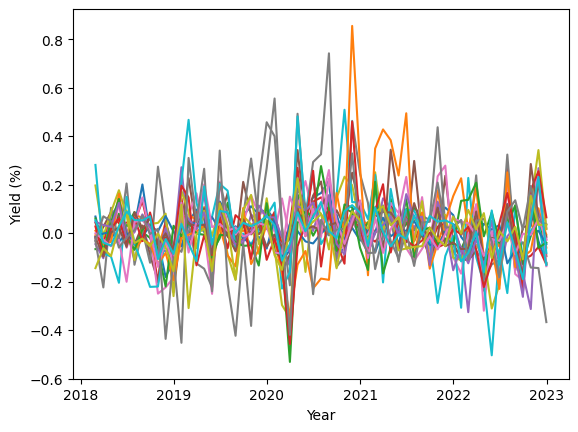

In [4]:
plt.plot(monthly_returns)
plt.xlabel("Year")
plt.ylabel("Yield (%)")
plt.show()

Offspring Size700
[0](0.17756320490825558
[last](0.011080436516694353))
Offspring Size700
[0](0.17756320490825558
[last](0.012182620647359687))
Offspring Size700
[0](0.17756320490825558
[last](0.013226341218988715))
Offspring Size700
[0](0.17756320490825558
[last](0.015554826944965303))
Offspring Size700
[0](0.17756320490825558
[last](0.015112683881719815))
Offspring Size700
[0](0.17756320490825558
[last](0.015314821429210389))
Offspring Size700
[0](0.17756320490825558
[last](0.01466333891286889))
Offspring Size700
[0](0.17756320490825558
[last](0.014804400634586684))
Offspring Size700
[0](0.17756320490825558
[last](0.015169388990925056))
Offspring Size700
[0](0.17756320490825558
[last](0.015377166849011147))
Offspring Size700
[0](0.17756320490825558
[last](0.015102057076757054))
Offspring Size700
[0](0.17756320490825558
[last](0.015266576876014825))
Offspring Size700
[0](0.17756320490825558
[last](0.015134276610379617))
Offspring Size700
[0](0.17756320490825558
[last](0.01497773886475

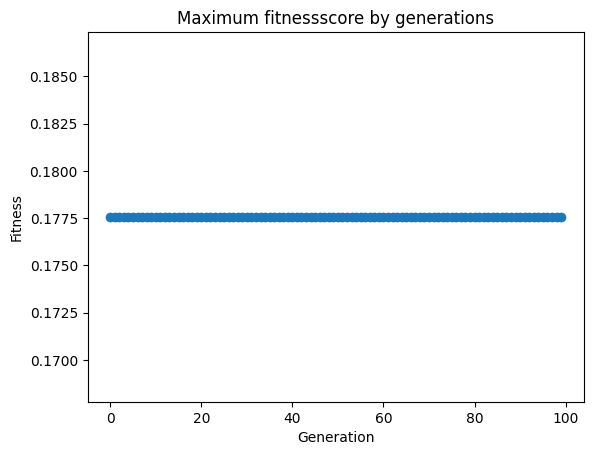

In [5]:
from es.es_factory import ESFactory
from utils.es_logger import ESLogger
logger = ESLogger()

factory = ESFactory(monthly_returns=monthly_returns)
advanced_one = factory.create_basic(steps=1, population_size=100, offspring_size=700).fit(generations=100, logger=logger)
logger.flush()

Offspring Size700
[0](0.1673714675794299
[last](0.011509284713552493))
Offspring Size700
[0](0.1673714675794299
[last](0.012295839811767573))
Offspring Size700
[0](0.1673714675794299
[last](0.012836865458656654))
Offspring Size700
[0](0.1673714675794299
[last](0.011844272724932884))
Offspring Size700
[0](0.1673714675794299
[last](0.012217404957780955))
Offspring Size700
[0](0.1673714675794299
[last](0.012506939441217182))
Offspring Size700
[0](0.1673714675794299
[last](0.012216904655266406))
Offspring Size700
[0](0.1673714675794299
[last](0.012200350409620562))
Offspring Size700
[0](0.1673714675794299
[last](0.0120622225815867))
Offspring Size700
[0](0.1673714675794299
[last](0.01205023084252753))
Offspring Size700
[0](0.1673714675794299
[last](0.012268204114783096))
Offspring Size700
[0](0.1673714675794299
[last](0.012410677871353014))
Offspring Size700
[0](0.1673714675794299
[last](0.012135430568042012))
Offspring Size700
[0](0.1673714675794299
[last](0.012562302833488918))
Offspring

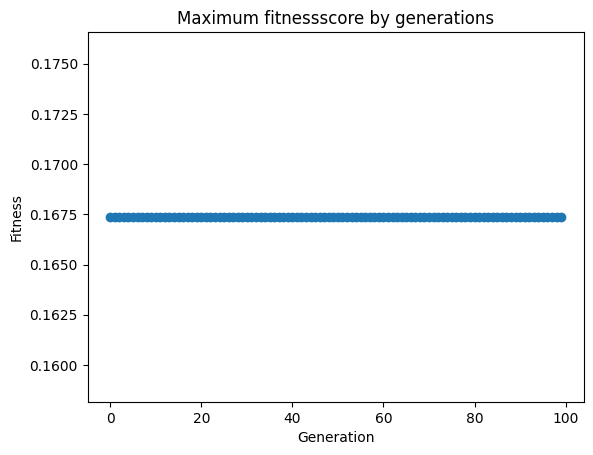

In [6]:
advanced_n = factory.create_basic(steps=len(STOCK_TICKERS), population_size=1, offspring_size=1) \
    .fit(generations=100, logger=logger)
logger.flush()

In [7]:
print(advanced_n[0].chromosone)
print(advanced_n[0].chromosone.sum())

[0.51863962 0.93547357 0.95587973 0.72785785 0.67901361 0.26360027
 0.71251917 0.98548456 0.70662156 0.84361096 0.43322547 0.61012883
 0.40294299 0.52756467 0.46386088 0.90821233 0.23902171 0.74208931
 0.60353321 0.89863869]
13.15791899532257
